### Experiments

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet50
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import PIL


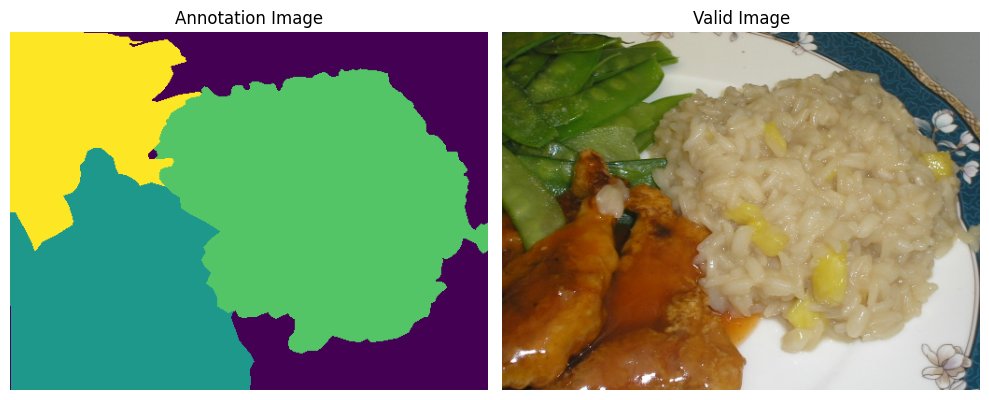

In [13]:
image = PIL.Image.open("/home/krrish/home/desktop/sensor-behaviour/data/Images/ann_dir/train/00000000.png")
valid = PIL.Image.open("/home/krrish/home/desktop/sensor-behaviour/data/Images/img_dir/train/00000000.jpg")

fig, axis = plt.subplots(1, 2, figsize=(10, 5))
axis[0].imshow(image)
axis[0].set_title("Annotation Image")
axis[0].axis('off')

axis[1].imshow(valid)
axis[1].set_title("Valid Image")
axis[1].axis('off')

plt.tight_layout()
plt.show()
